##INTRODUCTION

This project is not set out to recommend any stocks. I'm not a trader, not even close. However, it is my interest to learn more about how to read stock charts and using technical indicators and see how it compare to trade based on speculation and news (of course, these two create volatility offering short term opportunities). I learned many of the code below from Derek Banas, an Udemy instructor. I recommend anyone interested in the same topic NOT to just copy the code. It helps to type out all the code, google/stackoverflow anything you don't understand, and most importantly, google the concept behind ichimoku cloud, moving average, etc.  Once you have a more than a basic understanding of the concept and the code, try to use the code to build your own portfolio and use the ichimoku cloud to test few trades. The data I used is a 5 year data, but it's good idea to run a 6 month and 1 year analysis to compare/analyze with the 5 year analysis. I didn't do it here so this notebook will be super long!

I only scratched the surface and there are so much more to learn! I will be continuing to learn more, create a Tableau visulization on the EDA, and building up this project 😃.

The data is from yfinance and https://www.nasdaq.com/market-activity/stocks/screener


The code is seperated into 3 parts:

1.  EDA on NYSE and NASDAQ

2.  Downloading Stock Data and Building the Ichimoku Cloud.

3.  Finding a Optimal Portfolio with Sharpe Ratio.





**Sidenote:** Due to the amount of time it required to download all the stocks from NASDAQ, I only picked the top 200 based on market cap. Of course, you can run on all of the NASDAQ tickers if you would like. 

**Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import time
import os
import seaborn as sns

**Obtain Stock Data from Yahoo Finance**

In [ ]:
#pip install yfinance

In [ ]:
import yfinance as yf

**Set Start and End Date**

In [ ]:
# Start end date defaults
S_DATE = "2017-02-01"
E_DATE = "2023-02-01"
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

**Getting the CSV on Some of My Selected Tickers**

In [ ]:
tickers = ['AMZN', 'COST', 'ADBE', 'QQQ', 'NVDA', 'VUG', 'VGT', 'VOO', 'SPY', 'ARKK', 'ADBE','NVDA', 'AMD', 'MSFT', 'DIS', 'WMT', 'TGT', 'HD']

for ticker in tickers:
  stock = yf.Ticker(ticker)
  df = stock.history(period="5y")
  df.sort_index(axis = 0.,  ascending=False)
  df.to_csv(ticker + '.csv')


##EDA on NASDAQ and NYSE

The goal of this notebook is to code the ichimoku cloud and finding a optimal portfolio based on cumulative returns. We run a EDA on the dataset, but may not impute or change or fill in some of the missing values. 

Data source: https://www.nasdaq.com/market-activity/stocks/screener

In [ ]:
nasdaq = pd.read_csv("/content/Nasdaq.csv")
nasdaq.head(3)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$156.77,-9.25,-5.57%,2.717970e+12,United States,1980.0,130301346,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$277.35,-12.63,-4.36%,2.074310e+12,United States,1986.0,43227749,Technology,Computer Software: Prepackaged Software
2,GOOG,Alphabet Inc. Class C Capital Stock,"$2,334.93",-116.57,-4.76%,1.537550e+12,United States,2004.0,2152902,Technology,Internet and Information Services


In [ ]:
nasdaq.shape

(8456, 11)

In [ ]:
nasdaq.dtypes

#IPO Year is in float64, most likely due to NaN values. 

Symbol         object
Name           object
Last Sale      object
Net Change    float64
% Change       object
Market Cap    float64
Country        object
IPO Year      float64
Volume          int64
Sector         object
Industry       object
dtype: object

In [ ]:
# Missing values

percent_missing = nasdaq.isnull().sum() * 100 / len(nasdaq)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values(by=['percent_missing'], ascending=False)

#nasdaq[nasdaq.isna().any(axis=1)]

,percent_missing
IPO Year,40.078051
Sector,16.934721
Industry,16.769158
Country,9.626301
Market Cap,5.451750
Symbol,0.000000
Name,0.000000
Last Sale,0.000000
Net Change,0.000000
% Change,0.000000


In [ ]:
# Duplicate values
percentage = nasdaq.duplicated(keep=False).value_counts(normalize=True) * 100
percentage

False    100.0
dtype: float64

Text(0, 0.5, 'IPO Year')

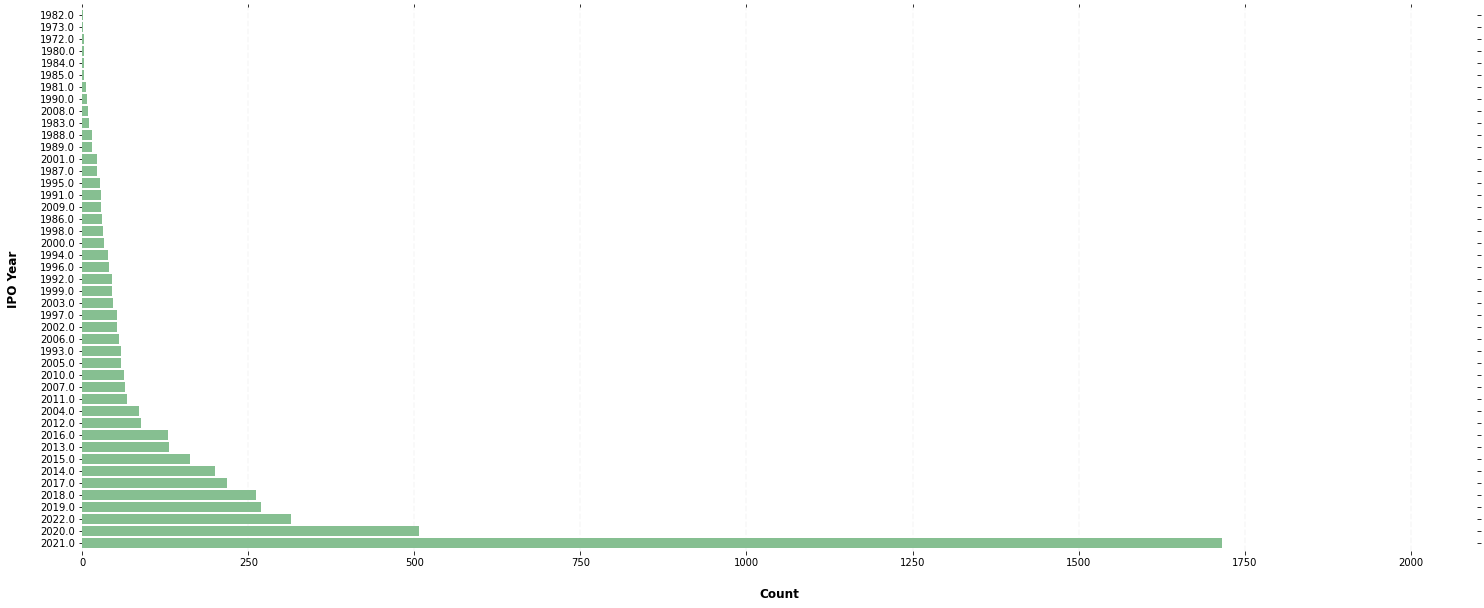

In [ ]:
ipo_year = nasdaq['IPO Year'].value_counts().sort_values(ascending=False)
ax = ipo_year.plot(kind='barh', figsize=(25, 10), color='#86bf91', zorder=2, width=0.85)

#Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

#Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
     ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Count", labelpad=20, weight='bold', size=12)
ax.set_ylabel("IPO Year", labelpad=20, weight='bold', size=12)

In [ ]:
ipo_year = nasdaq['IPO Year'].value_counts().sort_values(ascending=False)
ipo_year = list(reversed(list(ipo_year)))
ipo_year

#ax = ipo_year.plot(kind='barh', figsize=(25, 10), color='#86bf91', zorder=2, width=0.85)


[1,
 1,
 2,
 2,
 3,
 3,
 5,
 7,
 8,
 10,
 15,
 15,
 23,
 23,
 27,
 28,
 29,
 30,
 32,
 33,
 39,
 40,
 45,
 45,
 46,
 53,
 53,
 56,
 58,
 59,
 63,
 65,
 67,
 85,
 88,
 129,
 131,
 162,
 200,
 218,
 262,
 269,
 314,
 507,
 1716]

In [ ]:
nasdaq.describe()

,Net Change,Market Cap,IPO Year,Volume
count,8456.000000,7.995000e+03,5067.000000,8.456000e+03
mean,-2.652598,7.308153e+09,2015.118808,1.156824e+06
std,140.839257,5.511551e+10,8.920433,4.780175e+06
min,-12943.000000,0.000000e+00,1972.000000,1.000000e+00
25%,-0.770000,4.340401e+07,2013.000000,1.272450e+04
50%,-0.180000,3.380804e+08,2020.000000,1.203060e+05
75%,-0.010000,1.937318e+09,2021.000000,6.710232e+05
max,68.580000,2.717970e+12,2022.000000,1.530062e+08


In [ ]:
nasdaq.columns

Index(['Symbol', 'Name', 'Last Sale', 'Net Change', '% Change', 'Market Cap',
       'Country', 'IPO Year', 'Volume', 'Sector', 'Industry'],
      dtype='object')

In [ ]:
#print(nasdaq['Sector'].value_counts())
print(nasdaq['Sector'].value_counts(normalize=True)*100)

Finance                  34.681093
Health Care              16.400911
Technology               12.129841
Consumer Services        10.919704
Capital Goods             6.719818
Consumer Non-Durables     3.345672
Energy                    3.288724
Basic Industries          2.932802
Public Utilities          2.875854
Miscellaneous             2.676538
Consumer Durables         2.249431
Transportation            1.779613
Name: Sector, dtype: float64


Rows, Columns: (8456, 11)


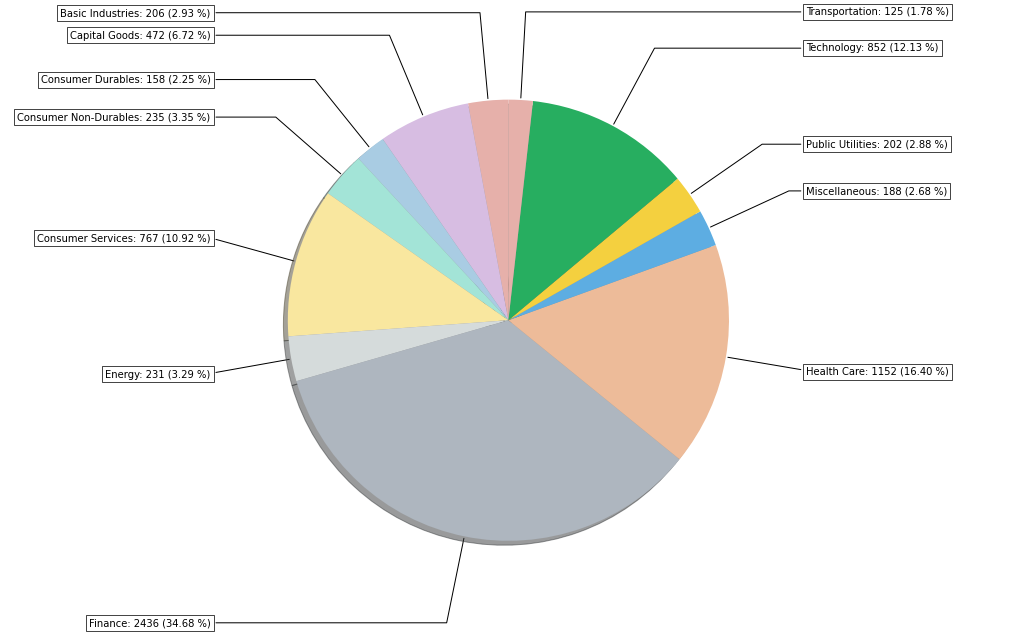

In [ ]:
print("Rows, Columns:",nasdaq.shape)
Sector = nasdaq.groupby('Sector').size()
labels = Sector.index.values
sizes = Sector.values
muestra = []
for k in range(0,labels.size):
  texto = labels[k]+': '+str(sizes[k])+' ({:,.2f} %)'.format((100*sizes[k]/sum(sizes)))
  muestra.append(texto)
colors = ['#E6B0AA','#D7BDE2','#A9CCE3','#A3E4D7','#F9E79F','#D5DBDB','#AEB6BF','#EDBB99','#5DADE2','#F4D03F','#27AE60']
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
fig,ax1 = plt.subplots(figsize=(18,9),ncols=1,nrows=1)
wedges, texts = ax1.pie(sizes, shadow=True, colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax1.annotate(muestra[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.show()

In [ ]:
nasdaq['Industry'].groupby(nasdaq['Sector']).value_counts()


Sector            Industry                
Basic Industries  Precious Metals             34
                  Major Chemicals             31
                  Steel/Iron Ore              28
                  Industrial Specialties      25
                  Agricultural Chemicals      12
                                              ..
Transportation    Railroads                    4
                  Advertising                  1
                  Hotels/Resorts               1
                  Rental/Leasing Companies     1
                  Transportation Services      1
Name: Industry, Length: 229, dtype: int64

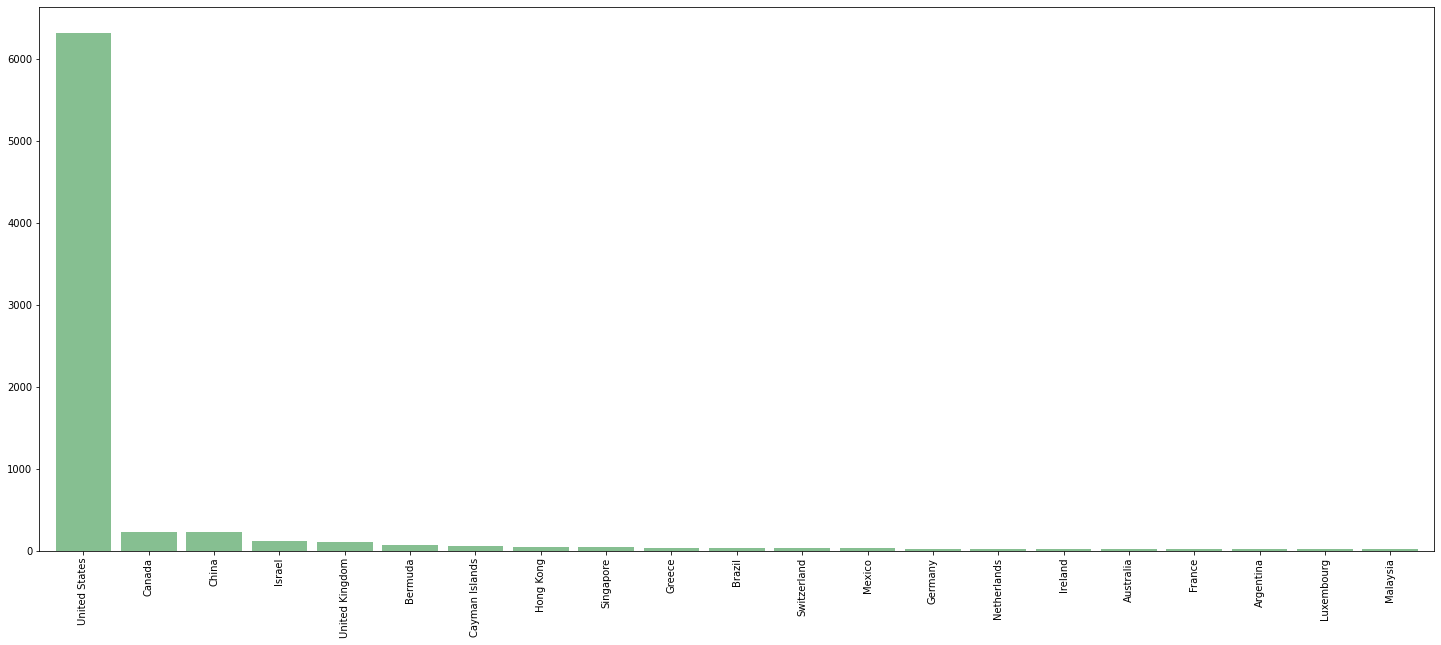

In [ ]:
country = nasdaq['Country'].value_counts()
country = country[0:21] 

ax = country.plot(kind='bar', figsize=(25, 10), color='#86bf91', zorder=2, width=0.85)


In [ ]:
nyse = pd.read_csv("/content/NYSE.csv")
nyse.head(3)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$122.15,-4.15,-3.286%,3.665885e+10,United States,1999.0,2123601,Capital Goods,Electrical Products
1,AA,Alcoa Corporation Common Stock,$63.46,-4.50,-6.622%,1.170334e+10,NaN,2016.0,6047237,Basic Industries,Metal Fabrications
2,AAC,Ares Acquisition Corporation Class A Ordinary ...,$9.83,-0.01,-0.102%,1.228750e+09,NaN,2021.0,171748,Finance,Business Services


In [ ]:
nyse.shape

(3164, 11)

In [ ]:
# Missing values

percent_missing = nyse.isnull().sum() * 100 / len(nyse)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values(by=['percent_missing'], ascending=False)

#nasdaq[nasdaq.isna().any(axis=1)]

,percent_missing
IPO Year,46.649810
Country,23.451327
Sector,22.724399
Industry,22.503161
Market Cap,13.874842
Symbol,0.000000
Name,0.000000
Last Sale,0.000000
Net Change,0.000000
% Change,0.000000


In [ ]:
nyse.describe()

,Net Change,Market Cap,IPO Year,Volume
count,3164.000000,2.725000e+03,1688.000000,3.164000e+03
mean,-5.586086,1.270120e+10,2012.750000,1.586688e+06
std,230.148489,3.926178e+10,9.177771,4.728141e+06
min,-12943.000000,0.000000e+00,1984.000000,1.000000e+00
25%,-1.315000,3.757152e+08,2007.000000,4.549625e+04
50%,-0.400000,1.614932e+09,2016.000000,2.726525e+05
75%,-0.100000,7.110138e+09,2020.000000,1.213185e+06
max,33.400000,6.109179e+11,2022.000000,9.560153e+07


In [ ]:
#print(nyse['Sector'].value_counts())
print(nyse['Sector'].value_counts(normalize=True)*100)

Finance                  33.824131
Consumer Services        15.541922
Technology                9.284254
Capital Goods             8.997955
Energy                    6.094070
Public Utilities          5.685072
Basic Industries          5.153374
Health Care               4.907975
Consumer Non-Durables     3.967280
Miscellaneous             2.535787
Transportation            2.535787
Consumer Durables         1.472393
Name: Sector, dtype: float64


Rows, Columns: (3164, 11)


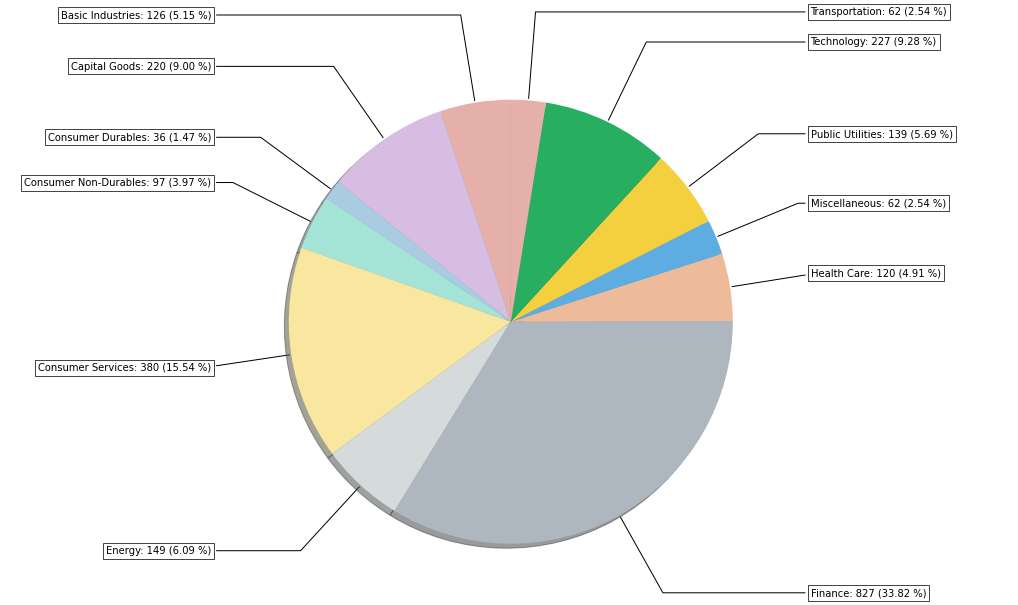

In [ ]:
print("Rows, Columns:",nyse.shape)
Sector = nyse.groupby('Sector').size()
labels = Sector.index.values
sizes = Sector.values
muestra = []
for k in range(0,labels.size):
  texto = labels[k]+': '+str(sizes[k])+' ({:,.2f} %)'.format((100*sizes[k]/sum(sizes)))
  muestra.append(texto)
colors = ['#E6B0AA','#D7BDE2','#A9CCE3','#A3E4D7','#F9E79F','#D5DBDB','#AEB6BF','#EDBB99','#5DADE2','#F4D03F','#27AE60']
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
fig,ax1 = plt.subplots(figsize=(18,9),ncols=1,nrows=1)
wedges, texts = ax1.pie(sizes, shadow=True, colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax1.annotate(muestra[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.show()

In [ ]:
country = nyse['Country'].value_counts()
country[0:21] 

United States     2040
Canada              70
Bermuda             48
China               36
United Kingdom      28
Brazil              20
Greece              16
Switzerland         13
Netherlands         11
Mexico              10
Argentina           10
Cayman Islands       9
Monaco               9
Japan                9
Luxembourg           8
Chile                8
South Korea          8
India                8
Ireland              7
South Africa         6
France               4
Name: Country, dtype: int64

**Downloading the Tickers from NASDAQ.csv**

In [ ]:
def get_column_from_csv(file, col_name):
    # Try to get the file and if it doesn't exist issue a warning
    try:
        df = pd.read_csv(file)
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df[col_name]

In [ ]:
tickers = get_column_from_csv("/content/Nasdaq.csv", "Symbol")
print(len(tickers))
tickers

8456


0         AAPL
1         MSFT
2         GOOG
3        GOOGL
4         AMZN
         ...  
8451     WRB^G
8452     WRB^H
8453     WSO/B
8454    XFLT^A
8455    YCBD^A
Name: Symbol, Length: 8456, dtype: object

In [ ]:
def save_to_csv_from_yahoo(folder, ticker):
    stock = yf.Ticker(ticker)
    
    try:
        print("Get Data for : ", ticker)
        # Get historical closing price data
        df = stock.history(period="5y")
    
        # Wait 2 seconds
        time.sleep(2)
        
        # Remove the period for saving the file name
        # Save data to a CSV file
        # File to save to 
        the_file = folder + ticker.replace(".", "_") + '.csv'
        print(the_file, " Saved")
        df.to_csv(the_file)
    except Exception as ex:
        print("Couldn't Get Data for :", ticker)

In [ ]:
PATH = "/content/"

*Due to the amount of tickers and the run time required for the code. I ran the top 199 tickers only in the NASDAQ base on market cap.*

In [ ]:
for x in range(0, 101):
    save_to_csv_from_yahoo(PATH, tickers[x])
    print("Finished")

Get Data for :  AAPL
/content/AAPL.csv  Saved
Finished
Get Data for :  MSFT
/content/MSFT.csv  Saved
Finished
Get Data for :  GOOG
/content/GOOG.csv  Saved
Finished
Get Data for :  GOOGL
/content/GOOGL.csv  Saved
Finished
Get Data for :  AMZN
/content/AMZN.csv  Saved
Finished
Get Data for :  TSLA
/content/TSLA.csv  Saved
Finished
Get Data for :  VFC
/content/VFC.csv  Saved
Finished
Get Data for :  FB
/content/FB.csv  Saved
Finished
Get Data for :  TSM
/content/TSM.csv  Saved
Finished
Get Data for :  NVDA
/content/NVDA.csv  Saved
Finished
Get Data for :  JNJ
/content/JNJ.csv  Saved
Finished
Get Data for :  UNH
/content/UNH.csv  Saved
Finished
Get Data for :  V
/content/V.csv  Saved
Finished
Get Data for :  WMT
/content/WMT.csv  Saved
Finished
Get Data for :  XOM
/content/XOM.csv  Saved
Finished
Get Data for :  PG
/content/PG.csv  Saved
Finished
Get Data for :  JPM
/content/JPM.csv  Saved
Finished
Get Data for :  MA
/content/MA.csv  Saved
Finished
Get Data for :  CVX
/content/CVX.csv  Sa

In [ ]:
def get_stock_df_from_csv(tickers):
  try:
    df = pd.read_csv(PATH + tickers + '.csv', index_col=0)
  except FileNotFoundError:
    print("File Doesn't Exist")
  else:
    return df

In [ ]:
get_stock_df_from_csv('SPY')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-05-08,219.699688,219.855469,219.168192,219.617218,48385700,0.0,0
2017-05-09,219.892135,220.102896,219.049063,219.415619,51363200,0.0,0
2017-05-10,219.369793,219.809647,219.149859,219.809647,54293800,0.0,0
2017-05-11,219.333167,219.534769,218.215194,219.360657,62358300,0.0,0
2017-05-12,219.094866,219.406428,218.709992,218.994064,53912700,0.0,0
...,...,...,...,...,...,...,...
2022-04-29,423.589996,425.869995,411.209991,412.000000,145187900,0.0,0
2022-05-02,412.070007,415.920013,405.019989,414.480011,158312500,0.0,0
2022-05-03,415.010010,418.929993,413.359985,416.380005,100028200,0.0,0


In [ ]:
from os import listdir
from os.path import isfile, join

files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
len(tickers)

110

In [ ]:
def add_daily_return_to_df(df):
  df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
  return df

In [ ]:
def add_cum_return_to_df(df):
  df['cum_return'] = (1 + df['daily_return']).cumprod()
  return df

In [ ]:
def add_bollinger_bands(df):
  df['middle_band'] = df['Close'].rolling(window=20).mean()
  df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
  df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()
  return df

In [ ]:
def add_ichimoku(df):
  #Conversion line
  hi_val = df['High'].rolling(window=9).max()
  lo_val = df['Low'].rolling(window=9).min()
  df['Conversion'] = (hi_val+lo_val)/2

  #Base Line
  hi_val2 = df['High'].rolling(window=26).max()
  lo_val2 = df['Low'].rolling(window=26).min()
  df['Baseline'] = (hi_val2+lo_val2)/2

  #Span A
  df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2)

  #Span B
  hi_val3 = df['High'].rolling(window=52).max()
  lo_val3 = df['Low'].rolling(window=52).min()
  df['SpanB'] = ((hi_val3 + lo_val3)/2).shift(26)

  #Laggine Span
  df['Lagging'] = df['Close'].shift(-26)
  return df



##What is the Ichimoku Cloud?

Ichimoku is a technical indicator. The 5 lines of the cloud are:

1. Tenkan Sen = Conversion Line: determine the direction of the short-term trend (yellow). Faster line. 
2. Kijun Sen = Base Line: avg for medium point and shows mid-term trend (red). Slower line.
3. Senkou Span A = Leading Span A (green)
4. Senkou Span B = Leading Span B (red)
5. Chikou Line = Lagging Span (teal): helps to confirm signal.


Few important concepts:
1. Formed between Span A and Span B, the **cloud** shows support and resistance.
2. Span A and Span B are set 26 periods into the future.  
3. Chikou represents the closing price and set 26 periods in the past. 
4. Wider the cloud, the stronger the trend. 
5. Try to not use the strategy for less than 1 hour. 


Reading the cloud:
1. Price is above the cloud: UP trend. Green color. Top of cloud is the support. 
2. Price is below the cloud: DOWN trend. Red color. Bottom of cloud is the resistant. 
3. Not recommended to trade when price is inside the cloud. Market is not trending. Use top of cloud as resistance and bottom as support. 
4. Tk/Golden Cross: when conversion past base from bottom to up, a **BUY** signal. If the price is above the cloud during this cross, it is a strong buy signal. If the price is below the cloud, you may want to wait until price is on top of the cloud. If the lagging span is crossing the price at the same time at the same direction, it's also another signal on buy. Set the stop loss at the narest local minimum.
5. Death Cross: when conversion past base from top to bottom, a **SELL** signal. If the price is below the cloud during this cross, it is a strong sell signal. If the price is above the cloud, you may want to wait until price is on bottom of the cloud before entering short positions. Set the stop loss at the narest local maximum.

Strategy Visualization: [ichimoku](https://yukiphotostudio.pixieset.com/ichimoku/)

In [ ]:
for x in tickers:
  try:
    print("Working on:", x)
    new_df = get_stock_df_from_csv(x)
    new_df = add_daily_return_to_df(new_df)
    new_df = add_cum_return_to_df(new_df)
    new_df = add_bollinger_bands(new_df)
    new_df = add_ichimoku(new_df)
    new_df.to_csv(PATH + x + '.csv')
  except Exception as ex:
    print(ex)

Working on: NVO
Working on: ABT
Working on: UNP
Working on: JPM
Working on: COP
Working on: LIN
Working on: EQNR
Working on: SPGI
Working on: UPS
Working on: AMZN
Working on: MS
Working on: V
Working on: DE
Working on: TTE
Working on: ACN
Working on: GSK
Working on: ARKK
Working on: HSBC
Working on: TSM
Working on: AVGO
Working on: VOO
Working on: PM
Working on: LMT
Working on: UNH
Working on: ASML
Working on: TM
Working on: SONY
Working on: CRM
Working on: GOOGL
Working on: QQQ
Working on: CVX
Working on: SPY
Working on: T
Working on: LOW
Working on: IBM
Working on: TSLA
Working on: MDT
Working on: FMX
Working on: HD
Working on: INTC
Working on: VGT
Working on: PG
Working on: NVS
Working on: LLY
Working on: BABA
Working on: GOOG
Working on: KO
Working on: TGT
Working on: COST
Working on: FB
Working on: TMUS
Working on: CAT
Working on: PLD
Working on: GS
Working on: TXN
Working on: MA
Working on: MSFT
Working on: ABBV
Working on: EL
Working on: SCHW
Working on: AMD
Working on: AMGN
Wor

**Testing on Costco stock**

In [ ]:
df = pd.read_csv('/content/SPY.csv', index_col=0)

#daily return
df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1

#cumulative return
df['cum_return'] = (1 + df['daily_return']).cumprod()

#moving average 20 days
df['middle_band'] = df['Close'].rolling(window=20).mean()
df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()

#Conversion line
hi_val = df['High'].rolling(window=9).max()
lo_val = df['Low'].rolling(window=9).min()
df['Conversion'] = (hi_val+lo_val)/2

#Base Line
hi_val2 = df['High'].rolling(window=26).max()
lo_val2 = df['Low'].rolling(window=26).min()
df['Baseline'] = (hi_val2+lo_val2)/2

#Span A
df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2)

#Span B
hi_val3 = df['High'].rolling(window=52).max()
lo_val3 = df['Low'].rolling(window=52).min()
df['SpanB'] = ((hi_val3 + lo_val3)/2).shift(26)

#Laggine Span
df['Lagging'] = df['Close'].shift(-26)

#return df
df


,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_return,cum_return,middle_band,upper_band,lower_band,Conversion,Baseline,SpanA,SpanB,Lagging
Date,,,,,,,,,,,,,,,,,
2017-05-08,219.699688,219.855469,219.168192,219.617218,48385700,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223.814178
2017-05-09,219.892135,220.102896,219.049063,219.415619,51363200,0.0,0,-0.000918,0.999082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223.383469
2017-05-10,219.369793,219.809647,219.149859,219.809647,54293800,0.0,0,0.001796,1.000876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223.432281
2017-05-11,219.333167,219.534769,218.215194,219.360657,62358300,0.0,0,-0.002043,0.998832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.292389
2017-05-12,219.094866,219.406428,218.709992,218.994064,53912700,0.0,0,-0.001671,0.997163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223.772964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,423.589996,425.869995,411.209991,412.000000,145187900,0.0,0,-0.036956,1.875991,437.821501,462.752984,412.890018,430.610001,436.639999,433.625000,440.551391,NaN
2022-05-02,412.070007,415.920013,405.019989,414.480011,158312500,0.0,0,0.006019,1.887284,435.899501,461.797503,410.001499,427.514999,433.544998,430.529999,440.551391,NaN
2022-05-03,415.010010,418.929993,413.359985,416.380005,100028200,0.0,0,0.004584,1.895935,433.878502,459.234049,408.522955,427.514999,433.544998,430.529999,440.551391,NaN


In [ ]:
def plot_with_boll_bands(df, ticker):
  fig = go.Figure()

  candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

  upper_line = go.Scatter(x=df.index, y=df['upper_band'], 
                          line=dict(color='rgba(250,0,0,0.75)',
                          width=1), name='Upper Band')

  mid_line = go.Scatter(x=df.index, y=df['middle_band'], 
                          line=dict(color='rgba(0,0,250,0.75)',
                          width=1), name='Middle Band')
  
  lower_line = go.Scatter(x=df.index, y=df['lower_band'], 
                          line=dict(color='rgba(0,25,0,0.75)',
                          width=1), name='Lower Band')
  
  fig.add_trace(candle)
  fig.add_trace(upper_line)
  fig.add_trace(mid_line)
  fig.add_trace(lower_line)

  fig.update_xaxes(title='Date', rangeslider_visible=True)
  fig.update_yaxes(title='Price')

  fig.update_layout(title="Bollinger Bands", height=1200, width=1800, showlegend=True)

  fig.show()

In [ ]:
import plotly.graph_objs as go

fig = go.Figure()

candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

upper_line = go.Scatter(x=df.index, y=df['upper_band'], 
                          line=dict(color='rgba(250,0,0,0.75)',
                          width=1), name='Upper Band')

mid_line = go.Scatter(x=df.index, y=df['middle_band'], 
                          line=dict(color='rgba(0,0,250,0.75)',
                          width=1), name='Middle Band')
  
lower_line = go.Scatter(x=df.index, y=df['lower_band'], 
                          line=dict(color='rgba(0,25,0,0.75)',
                          width=1), name='Lower Band')
  
fig.add_trace(candle)
fig.add_trace(upper_line)
fig.add_trace(mid_line)
fig.add_trace(lower_line)

fig.update_xaxes(title='Date', rangeslider_visible=True)
fig.update_yaxes(title='Price')

fig.update_layout(title="Bollinger Bands", height=800, width=1300, showlegend=True)

#fig.show()

In [ ]:
def get_fill_color(label):
    if label >= 1:
        return 'rgba(0,250,0,0.2)'
    else:
        return 'rgba(250,0,0,0.2)'

In [ ]:
def get_ichimoku(df):
  candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

  df1 = df.copy()
  fig = go.Figure()
  df['label'] = np.where(df['SpanA'] > df['SpanB'], 1, 0) #return 1 for green, return 0 for red
  df['group'] = df['label'].ne(df['label'].shift()).cumsum()
  df = df.groupby('group')

  dfs = []
  for name, data in df:
    dfs.append(data)
  for df in dfs:
    fig.add_traces(go.Scatter(x=df.index, y=df.SpanA,
        line=dict(color='rgba(0,0,0,0)')))

    fig.add_traces(go.Scatter(x=df.index, y=df.SpanB,
        line=dict(color='rgba(0,0,0,0)'),
        fill='tonexty',
        fillcolor=get_fill_color(df['label'].iloc[0])))
    
  baseline = go.Scatter(x=df1.index, y=df1['Baseline'],
                        line=dict(color='red', width=3), name='Baseline')
  
  conversion = go.Scatter(x=df1.index, y=df1['Conversion'],
                          line=dict(color='gold', width=3), name='Conversion')
  
  lagging = go.Scatter(x=df1.index, y=df1['Lagging'],
                          line=dict(color='purple', width=2), name='Lagging')
  
  span_a = go.Scatter(x=df1.index, y=df1['SpanA'],
                          line=dict(color='green', width=2, dash='dot'), name='Span A')
  
  span_b = go.Scatter(x=df1.index, y=df1['SpanB'],
                          line=dict(color='red', width=2, dash='dot'), name='Span B')
  
  fig.add_trace(candle)
  fig.add_trace(baseline)
  fig.add_trace(conversion)
  fig.add_trace(lagging)
  fig.add_trace(span_a)
  fig.add_trace(span_b)

  fig.update_layout(height=800, width=1300, showlegend=True)

  fig.show()



In [ ]:
spy = get_stock_df_from_csv('COST')
get_ichimoku(spy)

##Optimal Portfolio

In [ ]:
#sec_df = pd.read_csv('/content/big_stock_sectors.csv')
sec_df = pd.read_csv('/content/Nasdaq.csv')

In [ ]:
sec_df.rename(columns={'Symbol': 'Ticker'}, inplace=True)


In [ ]:
sec_df.head()

,Ticker,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$156.77,-9.25,-5.57%,2.717970e+12,United States,1980.0,130301346,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$277.35,-12.63,-4.36%,2.074310e+12,United States,1986.0,43227749,Technology,Computer Software: Prepackaged Software
2,GOOG,Alphabet Inc. Class C Capital Stock,"$2,334.93",-116.57,-4.76%,1.537550e+12,United States,2004.0,2152902,Technology,Internet and Information Services
3,GOOGL,Alphabet Inc. Class A Common Stock,"$2,330.11",-115.11,-4.71%,1.534380e+12,United States,NaN,2288253,Technology,Internet and Information Services
4,AMZN,Amazon.com Inc. Common Stock,"$2,328.14",-190.43,-7.56%,1.184370e+12,United States,1997.0,7208035,Consumer Services,Catalog/Specialty Distribution


In [ ]:
sec_df['Sector'].value_counts()

Finance                  2436
Health Care              1152
Technology                852
Consumer Services         767
Capital Goods             472
Consumer Non-Durables     235
Energy                    231
Basic Industries          206
Public Utilities          202
Miscellaneous             188
Consumer Durables         158
Transportation            125
Name: Sector, dtype: int64

In [ ]:
finance_df = sec_df.loc[sec_df['Sector'] == "Finance"]
health_df = sec_df.loc[sec_df['Sector'] == "Health Care"]
tech_df = sec_df.loc[sec_df['Sector'] == "Technology"]
consumer_df = sec_df.loc[sec_df['Sector'] == "Consumer Services"]
goods_df = sec_df.loc[sec_df['Sector'] == "Capital Goods"]
nondurables_df = sec_df.loc[sec_df['Sector'] == "Consumer Non-Durables"]
energy_df = sec_df.loc[sec_df['Sector'] == "Energy"]
public_utilities_df = sec_df.loc[sec_df['Sector'] == "Public Utilities"]
industries_df = sec_df.loc[sec_df['Sector'] == "Basic Industries"]
misc_df = sec_df.loc[sec_df['Sector'] == "Miscellaneous"]
durables_df = sec_df.loc[sec_df['Sector'] == "Consumer Durables"]
transportation_df = sec_df.loc[sec_df['Sector'] == "Transportation"]


In [ ]:
tech_df

,Ticker,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$156.77,-9.2500,-5.57%,2.717970e+12,United States,1980.0,130301346,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$277.35,-12.6300,-4.36%,2.074310e+12,United States,1986.0,43227749,Technology,Computer Software: Prepackaged Software
2,GOOG,Alphabet Inc. Class C Capital Stock,"$2,334.93",-116.5700,-4.76%,1.537550e+12,United States,2004.0,2152902,Technology,Internet and Information Services
3,GOOGL,Alphabet Inc. Class A Common Stock,"$2,330.11",-115.1100,-4.71%,1.534380e+12,United States,NaN,2288253,Technology,Internet and Information Services
7,FB,Meta Platforms Inc. Class A Common Stock,$208.28,-15.1300,-6.77%,5.636730e+11,United States,2012.0,41102952,Technology,Internet and Information Services
...,...,...,...,...,...,...,...,...,...,...,...
7896,TRKAW,Troika Media Group Inc. Warrant,$0.11,0.0009,0.82%,0.000000e+00,United States,2021.0,6413,Technology,Advertising
7928,VENAR,Venus Acquisition Corporation Rights,$0.17,0.0200,13.33%,0.000000e+00,United States,2021.0,19512,Technology,EDP Services
7929,VENAU,Venus Acquisition Corporation Units,$10.13,0.0000,0.00%,0.000000e+00,United States,2021.0,1,Technology,EDP Services
7931,VERBW,Verb Technology Company Inc. Warrant,$0.26,-0.0300,-10.35%,0.000000e+00,United States,NaN,20427,Technology,EDP Services


In [ ]:
def get_cum_ret_for_stocks(stock_df):
    tickers = []
    cum_rets = []

    for index, row in stock_df.iterrows():
        df = get_stock_df_from_csv(row['Ticker'])
        if df is None:
            pass
        else:
            tickers.append(row['Ticker'])
            cum = df['cum_return'].iloc[-1]
            cum_rets.append(cum)
    return pd.DataFrame({'Ticker':tickers, 'CUM_RET':cum_rets})

In [ ]:
finance_df = get_cum_ret_for_stocks(finance_df)
health_df = get_cum_ret_for_stocks(health_df)
tech_df = get_cum_ret_for_stocks(tech_df)
consumer_df = get_cum_ret_for_stocks(consumer_df)
goods_df = get_cum_ret_for_stocks(goods_df)
nondurables_df = get_cum_ret_for_stocks(nondurables_df)
energy_df = get_cum_ret_for_stocks(energy_df)
public_utilities_df = get_cum_ret_for_stocks(public_utilities_df)
industries_df = get_cum_ret_for_stocks(industries_df)
misc_df = get_cum_ret_for_stocks(misc_df)
durables_df = get_cum_ret_for_stocks(durables_df)
transportation_df = get_cum_ret_for_stocks(transportation_df)


Streaming output truncated to the last 5000 lines.
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist

**Cumulative Return Performance Per Sector**

In [ ]:
print('Finance:')
print(finance_df .sort_values(by=['CUM_RET'], ascending=False).head(10))



Finance:
  Ticker   CUM_RET
6    AXP  2.349550
3     MS  2.247310
8    AMT  2.066569
5   SCHW  1.838005
4    HON  1.741698
1    BAC  1.738078
0    JPM  1.634152
9     GS  1.523891
7   HSBC  0.940332
2    WFC  0.935239


In [ ]:
print('Health:')
print(health_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Health:
   Ticker   CUM_RET
2     LLY  4.026711
10    DHR  3.094400
5     NVO  3.056017
1     UNH  3.055969
16   ANTM  2.998053
4    ABBV  2.888906
8     ABT  2.749557
7     AZN  2.519742
3     PFE  1.838727
6     MRK  1.683963


In [ ]:
print('Tech:')
print(tech_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Tech:
   Ticker   CUM_RET
17    AMD  9.349602
6    NVDA  7.423007
8    ASML  4.435171
0    AAPL  4.340678
1    MSFT  4.309725
21   INTU  3.372693
5     TSM  3.094534
7    AVGO  3.082253
15   QCOM  3.018944
11   ADBE  2.964106


In [ ]:
print('Consumer Services:')
print(consumer_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Consumer Services:
   Ticker   CUM_RET
10    TGT  4.607125
3    COST  3.227716
9     PLD  3.007121
8     LOW  2.487097
0    AMZN  2.453153
1     WMT  2.212944
2      HD  2.140861
5     MCD  1.945359
6   CMCSA  1.138434
4     DIS  1.055408


In [ ]:
print('Capital Goods:')
print(goods_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Capital Goods:
  Ticker    CUM_RET
0   TSLA  14.214005
5     DE   3.688178
2    TMO   3.273198
7   AMAT   2.908311
6    CAT   2.457862
4    LMT   1.854813
1     TM   1.542154
3    RTX   1.424871


In [ ]:
print('Nondurables:')
print(nondurables_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Nondurables:
   Ticker   CUM_RET
5      EL  2.736034
10   SONY  2.415529
4     NKE  2.299422
1      PG  2.048453
9     DEO  1.830594
3     PEP  1.742761
2      KO  1.727940
6      PM  1.158134
11     MO  1.092693
0     VFC  1.078324


In [ ]:
print('Energy:')
print(energy_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Energy:
  Ticker   CUM_RET
4    COP  2.504265
5   EQNR  2.431085
1    CVX  1.949322
0    XOM  1.417528
3    TTE  1.359633
2   SHEL  1.349574
6     BP  1.191889


In [ ]:
print('Public Utilities:')
print(public_utilities_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Public Utilities:
  Ticker   CUM_RET
2    NEE  2.391173
1   TMUS  1.958579
0     VZ  1.283537


In [ ]:
#Top 10 in other sectors:

print(industries_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(misc_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(durables_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(transportation_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

  Ticker   CUM_RET
2    RIO  2.801427
1    LIN  2.655444
0    BHP  2.394261
  Ticker   CUM_RET
1     MA  3.114232
0      V  2.305591
2   BABA  0.809858
Empty DataFrame
Columns: [Ticker, CUM_RET]
Index: []
  Ticker   CUM_RET
1    UNP  2.336806
0    UPS  1.943876


In [ ]:
# For all sectors combined
sec_cumret_df = get_cum_ret_for_stocks(sec_df)


Streaming output truncated to the last 5000 lines.
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist

In [ ]:
# Start end date defaults
S_DATE = "2017-02-01"
E_DATE = "2023-02-01"
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

risk_free_rate = 0.0125

In [ ]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
tickers


['NVO',
 'ABT',
 'UNP',
 'JPM',
 'COP',
 'LIN',
 'EQNR',
 'SPGI',
 'UPS',
 'AMZN',
 'MS',
 'V',
 'DE',
 'TTE',
 'ACN',
 'GSK',
 'ARKK',
 'HSBC',
 'TSM',
 'AVGO',
 'VOO',
 'PM',
 'LMT',
 'UNH',
 'ASML',
 'TM',
 'SONY',
 'CRM',
 'GOOGL',
 'QQQ',
 'CVX',
 'SPY',
 'T',
 'LOW',
 'IBM',
 'TSLA',
 'MDT',
 'FMX',
 'HD',
 'INTC',
 'VGT',
 'PG',
 'NVS',
 'LLY',
 'BABA',
 'GOOG',
 'KO',
 'TGT',
 'COST',
 'FB',
 'TMUS',
 'CAT',
 'PLD',
 'GS',
 'TXN',
 'MA',
 'MSFT',
 'ABBV',
 'EL',
 'SCHW',
 'AMD',
 'AMGN',
 'WMT',
 'AMAT',
 'UL',
 'TMO',
 'VUG',
 'RY',
 'AAPL',
 'TD',
 'Nasdaq',
 'DEO',
 'SHEL',
 'BAC',
 'MO',
 'MCD',
 'BMY',
 'XOM',
 'SAP',
 'RIO',
 'AXP',
 'ADBE',
 'VZ',
 'VFC',
 'DIS',
 'HON',
 'MRK',
 'RTX',
 'PFE',
 'PEP',
 'BHP',
 'NEE',
 'NKE',
 'ANTM',
 'big_stock_sectors',
 'JNJ',
 'DHR',
 'NYSE',
 'CVS',
 'AMT',
 'NVDA',
 'WFC',
 'AZN',
 'INTU',
 'QCOM',
 'ORCL',
 'CSCO',
 'CMCSA',
 'SNY',
 'BP']

In [ ]:
def get_stock_df_from_csv(tickers):
  try:
    df = pd.read_csv(PATH + tickers + '.csv', index_col=0)
  except FileNotFoundError:
    print("File Doesn't Exist")
  else:
    return df

In [ ]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
  mult_df = pd.DataFrame()

  for x in tickers:
    df = get_stock_df_from_csv(x)
    mask = (df.index >= sdate) & (df.index <=edate)
    mult_df[x] = df.loc[mask][col_name]
  
  return mult_df

##Portfolio List

As the introduction stated, this project is not set out to recommend any stocks. I'm not a trader, not even close. Ideally, you should pick out some tickers from each sector and create a diverify portofolio. In this notebook, I just picked the top 10 based on cumulative return of the last 5 year. The top 10 may be different if you run your analysis on a 6 month, 1 year, 26 weeks, ettc etc. 

In [ ]:
print('ALL sectors:')
top_10 = sec_cumret_df.sort_values(by=['CUM_RET'], ascending=False).head(15)
top_10

ALL sectors:


,Ticker,CUM_RET
5,TSLA,14.214005
60,AMD,9.349602
9,NVDA,7.423007
96,TGT,4.607125
31,ASML,4.435171
0,AAPL,4.340678
1,MSFT,4.309725
22,LLY,4.026711
85,DE,3.688178
86,INTU,3.372693


In [ ]:
port_list = top_10['Ticker'].tolist()
port_list

['TSLA',
 'AMD',
 'NVDA',
 'TGT',
 'ASML',
 'AAPL',
 'MSFT',
 'LLY',
 'DE',
 'INTU',
 'TMO',
 'COST',
 'MA',
 'TSM',
 'DHR']

In [ ]:
#5 Year Price Changes

mult_df = merge_df_by_column_name('Close', S_DATE, E_DATE, *port_list)
mult_df

,TSLA,AMD,NVDA,TGT,ASML,AAPL,MSFT,LLY,DE,INTU,TMO,COST,MA,TSM,DHR
Date,,,,,,,,,,,,,,,
2017-05-08,61.438000,10.040000,25.385939,50.087635,127.203659,36.116478,64.354454,72.607651,103.856155,121.523056,168.187180,160.274307,113.469391,29.778316,81.408356
2017-05-09,64.251999,10.180000,25.427940,50.769455,128.816757,36.347790,64.447800,72.715660,104.722839,122.062431,169.894867,160.311447,113.274796,30.144367,81.193588
2017-05-10,65.043999,10.790000,29.960701,51.057911,127.709564,36.175495,64.699829,72.949692,104.695190,122.409172,168.759720,159.538635,113.508324,30.144367,81.232635
2017-05-11,64.620003,11.070000,31.247660,49.003708,128.053192,36.488342,63.906372,72.668869,104.621414,122.206909,168.799210,159.454849,113.391571,30.272062,80.812843
2017-05-12,64.961998,11.260000,31.591011,48.776432,129.274887,36.997921,63.831696,72.641678,104.289490,121.850510,169.302582,159.101044,113.975403,30.110319,80.871429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,870.760010,85.519997,185.470001,228.649994,559.633728,157.649994,277.519989,292.130005,377.549988,418.750000,552.919983,531.719971,363.380005,92.930000,251.130005
2022-05-02,902.940002,89.839996,195.330002,229.779999,566.900024,157.960007,284.470001,289.559998,381.230011,427.010010,545.520020,528.950012,359.040009,93.760002,250.520004
2022-05-03,909.250000,91.129997,196.020004,232.539993,570.679993,159.479996,281.779999,288.070007,389.440002,430.839996,546.320007,528.080017,357.790009,93.629997,248.509995


In [ ]:
import plotly.express as px

fig = px.line(mult_df, x=mult_df.index, y=mult_df.columns)
fig.update_xaxes(title="Date", rangeslider_visible=True)
fig.update_yaxes(title="Price")
fig.update_layout(height=800, width=1200, 
                  showlegend=True)
fig.show()

In [ ]:
returns = np.log(mult_df / mult_df.shift(1))
mean_ret = returns.mean()*100 * 252  #252 trading days
mean_ret

TSLA    53.168950
AMD     44.777751
NVDA    40.155424
TGT     30.600653
ASML    29.838687
AAPL    29.407290
MSFT    29.263933
LLY     27.903287
DE      26.144151
INTU    24.352887
TMO     23.753056
COST    23.472756
MA      22.755771
TSM     22.628663
DHR     22.627797
dtype: float64

**In general, you may want to pick a portfolio combination with correlaton less than 0.50.**

However, I generally don't follow this rule! If you want to stay focus and be a disciplined trader to pick out your optimal portfolio, then a correlation matrix definitely can help. 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



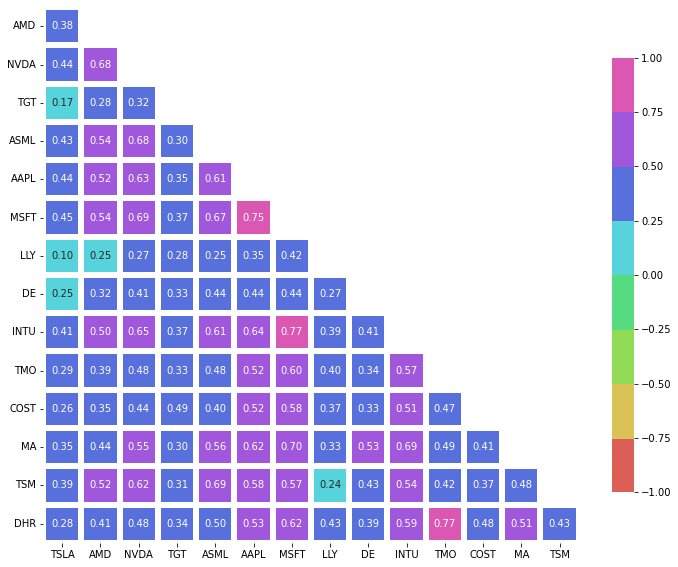

In [ ]:
corr = returns.corr()

# Correlation heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=np.bool))

mask = mask[1:, :-1]
corr = corr.iloc[1:,:-1].copy()

cmap = sns.color_palette("hls", 8)

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)

yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

plt.show()

In [ ]:
# Weights of each stock in the portfolio list. Will be random each time. 

num_stocks = len(port_list)
num_stocks

weights = np.random.random(num_stocks)
weights /= np.sum(weights)
print('Weights:', weights)
print('Total Weights:', np.sum(weights))


Weights: [0.0302679  0.10460798 0.06055785 0.05966932 0.09685002 0.0054234
 0.10024587 0.06203466 0.09599806 0.03885474 0.10993272 0.03323702
 0.11094272 0.04917143 0.04220632]
Total Weights: 1.0000000000000002


In [ ]:
#Return

np.sum(weights * returns.mean()) * 252 

#252 trading days, annualized return over 5 years of time with random weights, pecentage return based off a randomly generated portfolio.

0.2970471515818767

In [ ]:
#Volatility

np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))   

#linear algebra of dot product, risk percentage based off a randomly generated portfolio.

0.25095798255826535

In [ ]:
#Return and Risk of 10000 Combinations

p_ret = []   #return list
p_vol = []   #volatility risk, std from mean
p_SR = []
p_wt = []     #amt of each stock we have

for x in range(10000):
  p_weights = np.random.random(num_stocks)
  p_weights /= np.sum(p_weights)

  ret_1 = np.sum(p_weights * returns.mean()) * 252
  p_ret.append(ret_1)

  vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 252, p_weights)))
  p_vol.append(vol_1)

  SR_1 = (ret_1 - risk_free_rate) / vol_1
  p_SR.append(SR_1)

  p_wt.append(p_weights)

p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt




(array([0.31640513, 0.30435917, 0.29330572, ..., 0.28687763, 0.29989624,
        0.27359195]),
 array([0.26498278, 0.25043967, 0.23635761, ..., 0.23787992, 0.25392431,
        0.2404689 ]),
 array([1.14688635, 1.16538712, 1.18805449, ..., 1.15342914, 1.13181856,
        1.08576184]),
 array([[0.1088035 , 0.02275099, 0.12183384, ..., 0.07946885, 0.00559096,
         0.05659954],
        [0.05663803, 0.07053303, 0.11524979, ..., 0.09304205, 0.00533612,
         0.0825943 ],
        [0.05979944, 0.03294319, 0.08820593, ..., 0.09488767, 0.06647459,
         0.08179252],
        ...,
        [0.04731438, 0.02204553, 0.04614904, ..., 0.02658594, 0.12450227,
         0.00672823],
        [0.02967338, 0.07112114, 0.11567593, ..., 0.05353527, 0.08588228,
         0.05944246],
        [0.0353808 , 0.00269258, 0.1319008 , ..., 0.05961448, 0.12107652,
         0.08334364]]))

        Return  Volatility
0     0.316405    0.264983
1     0.304359    0.250440
2     0.293306    0.236358
3     0.274062    0.240002
4     0.297077    0.247422
...        ...         ...
9995  0.305671    0.262581
9996  0.316690    0.255138
9997  0.286878    0.237880
9998  0.299896    0.253924
9999  0.273592    0.240469

[10000 rows x 2 columns]


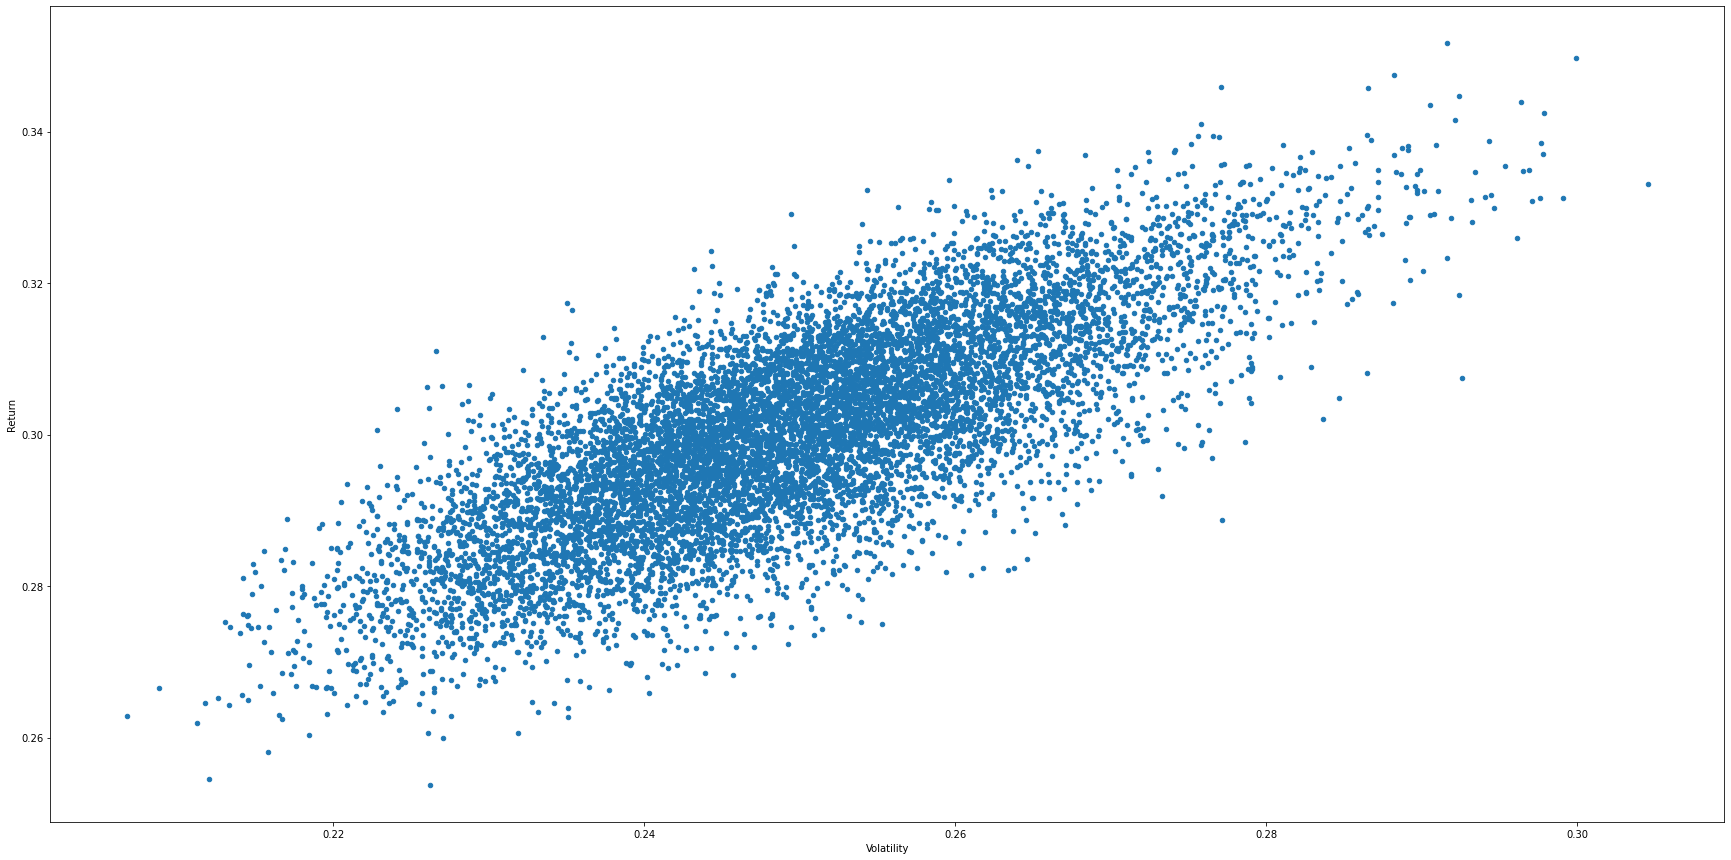

In [ ]:
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})
print(ports)
ports.plot(x='Volatility', y='Return', kind='scatter', figsize=(30,15))


In [ ]:
#Sharp Ratio

SR_idx = np.argmax(p_SR)

i = 0

while i < num_stocks: 
  print('Stock : %s : %2.2f' % (port_list[i],
                                (p_wt[SR_idx][i] * 100)))
  i+=1

print('\nVolatility:', p_vol[SR_idx])
print("Return: ", p_ret[SR_idx])

# percetenage for the stock, for example, you will buy costco for 13.37%

Stock : TSLA : 12.04
Stock : AMD : 2.62
Stock : NVDA : 0.05
Stock : TGT : 15.49
Stock : ASML : 7.27
Stock : AAPL : 13.33
Stock : MSFT : 6.15
Stock : LLY : 16.44
Stock : DE : 2.72
Stock : INTU : 1.14
Stock : TMO : 4.85
Stock : COST : 12.22
Stock : MA : 1.92
Stock : TSM : 0.74
Stock : DHR : 3.01

Volatility: 0.2265668503743594
Return:  0.3110911898833914


In [ ]:
def get_port_shares(one_price, force_one, wts, prices):
  num_stocks = len(wts)
  shares = []

  cost_shares = []

  i = 0
  while i < num_stocks: 
    max_price = one_price * wts[i]
    num_shares = int(max_price / prices[i])
    if(force_one & (num_shares == 0)):
      num_shares = 1
    shares.append(num_shares)
    cost = num_shares * prices[i]
    cost_shares.append(cost)
    i += 1
  return shares, cost_shares

In [ ]:
def get_port_weighting(share_cost):
    
    # Holds weights for stocks
    stock_wts = []
    # All values summed
    tot_val = sum(share_cost)
    print("Total Investment :", tot_val)
    
    for x in share_cost:
        stock_wts.append(x / tot_val)
    return stock_wts


In [ ]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, 
                                  date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    return port_prices

In [ ]:
#Convert the weights to percentage

port_wts = p_wt[SR_idx].tolist()
port_wts = [i*100 for i in port_wts]

port_wts

[12.04177896126175,
 2.6234970573445158,
 0.04982707565147853,
 15.48592126643352,
 7.265103147599781,
 13.330894301197702,
 6.153147290242765,
 16.44045031830681,
 2.7247337429879326,
 1.1436228704634366,
 4.851919180812879,
 12.216859954842574,
 1.9186209816861606,
 0.742104958907805,
 3.011518892260904]

In [ ]:
#In the final output, we will need to find the price of the stock with the minimal weight (or weight closest to 1). This is the one_price of function get_port_shares(one_price, force_one, wts, prices)

def get_price_at_min_weight(ticker_list,weights,price):
  df = pd.DataFrame({'Ticker': ticker_list,
                   'Weights': weights,
                   'Price': price})

  min = df[df['Weights'] == df['Weights'].min()]
  min_price = min['Price']
  return(min_price)

min_price = get_price_at_min_weight(port_list, port_wts, port_prices)


In [ ]:
# Getting the previous trading day and convert back to string to use in the next function.

from datetime import timedelta
 
# Get today's date
today = datetime.date.today()

 
# Yesterday date
yesterday = today - timedelta(days = 1)
yesterday = yesterday.strftime('%Y-%m-%d')
type(yesterday)
yesterday

'2022-05-05'

In [ ]:
# Get all stock prices on the starting date
port_df_start = merge_df_by_column_name('Close',  yesterday, 
                                  yesterday, *port_list)

# Convert from dataframe to Python list
port_prices = port_df_start.values.tolist()

# Trick that converts a list of lists into a single list
port_prices = sum(port_prices, [])

tot_shares, share_cost = get_port_shares(get_price_at_min_weight(port_list, port_wts, port_prices), True, port_wts, port_prices)
print("Shares :", tot_shares)
print("Share Cost :", share_cost)

# Get list of weights for stocks
stock_wts = get_port_weighting(share_cost)
print("Stock Weights :", stock_wts)

# Get value at end of year
get_port_val_by_date(E_DATE, tot_shares, port_list)

Shares : [2, 5, 1, 12, 2, 16, 4, 10, 1, 1, 1, 4, 1, 1, 2]
Share Cost : [1746.56005859375, 469.3500137329102, 188.44000244140625, 2769.119934082032, 1128.3399658203125, 2508.320068359375, 1109.4000244140625, 2923.699951171875, 383.0400085449219, 409.8599853515625, 550.510009765625, 2069.280029296875, 353.3699951171875, 92.1500015258789, 503.82000732421864]
Total Investment : 17205.260055541992
Stock Weights : [0.10151314498912005, 0.027279448971869954, 0.010952464643549969, 0.16094612491428573, 0.06558110497474652, 0.14578797764532592, 0.06448028224116922, 0.16993058760713825, 0.022262959543092795, 0.02382178380497901, 0.03199661080323515, 0.12027019775445583, 0.020538486136009514, 0.0053559202957932876, 0.02928290567522884]


[]

#SUMMARY

In [ ]:
port_df_start

,TSLA,AMD,NVDA,TGT,ASML,AAPL,MSFT,LLY,DE,INTU,TMO,COST,MA,TSM,DHR
Date,,,,,,,,,,,,,,,
2022-05-05,873.280029,93.870003,188.440002,230.759995,564.169983,156.770004,277.350006,292.369995,383.040009,409.859985,550.51001,517.320007,353.369995,92.150002,251.910004


In [ ]:
print('Volatility:', p_vol[SR_idx]*100)
print('Return: ', p_ret[SR_idx]*100)
print('Total Share Needed: ', sum(tot_shares))
print('Total Share Cost: ', sum(share_cost))

Volatility: 22.65668503743594
Return:  31.10911898833914
Total Share Needed:  63
Total Share Cost:  17205.260055541992


In [ ]:
df = pd.DataFrame({'Ticker': port_list,
                   'Weights': port_wts,
                   'Shares': tot_shares,
                   'Closing Price': port_prices,
                   'Share Cost': share_cost,
                   'Cumulative Return': top_10['CUM_RET'],
                   'Mean Return': mean_ret.tolist()})

df

,Ticker,Weights,Shares,Closing Price,Share Cost,Cumulative Return,Mean Return
5,TSLA,12.041779,2,873.280029,1746.560059,14.214005,53.168950
60,AMD,2.623497,5,93.870003,469.350014,9.349602,44.777751
9,NVDA,0.049827,1,188.440002,188.440002,7.423007,40.155424
96,TGT,15.485921,12,230.759995,2769.119934,4.607125,30.600653
31,ASML,7.265103,2,564.169983,1128.339966,4.435171,29.838687
0,AAPL,13.330894,16,156.770004,2508.320068,4.340678,29.407290
1,MSFT,6.153147,4,277.350006,1109.400024,4.309725,29.263933
22,LLY,16.440450,10,292.369995,2923.699951,4.026711,27.903287
85,DE,2.724734,1,383.040009,383.040009,3.688178,26.144151
86,INTU,1.143623,1,409.859985,409.859985,3.372693,24.352887
